# German Bank Clients Clusterisation

## Import libraries

In [124]:
!pip install umap-learn

  Using cached umap_learn-0.5.3-py3-none-any.whl
  Using cached numba-0.56.2-cp38-cp38-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.5 MB)
  Using cached scipy-1.9.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.4 MB)
  Using cached scikit_learn-1.1.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)
  Using cached numpy-1.23.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached pynndescent-0.5.7-py3-none-any.whl
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached setuptools-59.8.0-py3-none-any.whl (952 kB)
  Using cached llvmlite-0.39.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.6 MB)
  Using cached importlib_metadata-4.12.0-py3-none-any.whl (21 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached zipp-3.8.1-py3-none-any.whl (5.6 kB)
ERROR: pip's dependency resolver does not currently take into account al

In [165]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import umap
from functools import partial
from math import ceil
from sklearn.preprocessing import (OrdinalEncoder, 
                                   MinMaxScaler)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from tqdm import tqdm

sns.set_style("whitegrid")

In [126]:
def multiple_plots(dataset, columns, vizfunc, xyrot=(0, 0), gwidth=4, gheight=4, ncol=3, **kwargs):
    nrow = ceil(len(columns)/ncol)
    fig, axes = plt.subplots(nrow, ncol)
    fig.set_size_inches(ncol*gwidth, nrow*gheight)
    for ax, col in zip(axes.flatten(), columns):
        vizfunc(data=df, x=col, ax=ax, **kwargs)
        ax.tick_params('x', labelrotation=xyrot[0])
        ax.tick_params('y', labelrotation=xyrot[1])
    return fig, axes

## Read data

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (text - little, moderate, quite rich, rich)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [127]:
df = pd.read_csv('german_credit_data.csv')
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,996,40,male,3,own,little,little,3857,30,car
997,997,38,male,2,own,little,NaN,804,12,radio/TV
998,998,23,male,2,free,little,little,1845,45,radio/TV


## EDA
Дропнем ненужную первую колонку:

In [128]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


## Categorical variables
Поле Job сконвертируем в текст для лучшей интерпретаци в ходе EDA.

In [130]:
job_map = {
    0: 'unskilled and non-resident',
    1: 'unskilled and resident',
    2: 'skilled',
    3: 'highly skilled'
}
df['Job_cat'] = df['Job'].map(job_map)

Сконвертируем все категориальные признаки в category:

In [131]:
cat_vars = df.select_dtypes('object').columns
df[cat_vars] = df[cat_vars].astype('category')

Теперь можем визуализировать

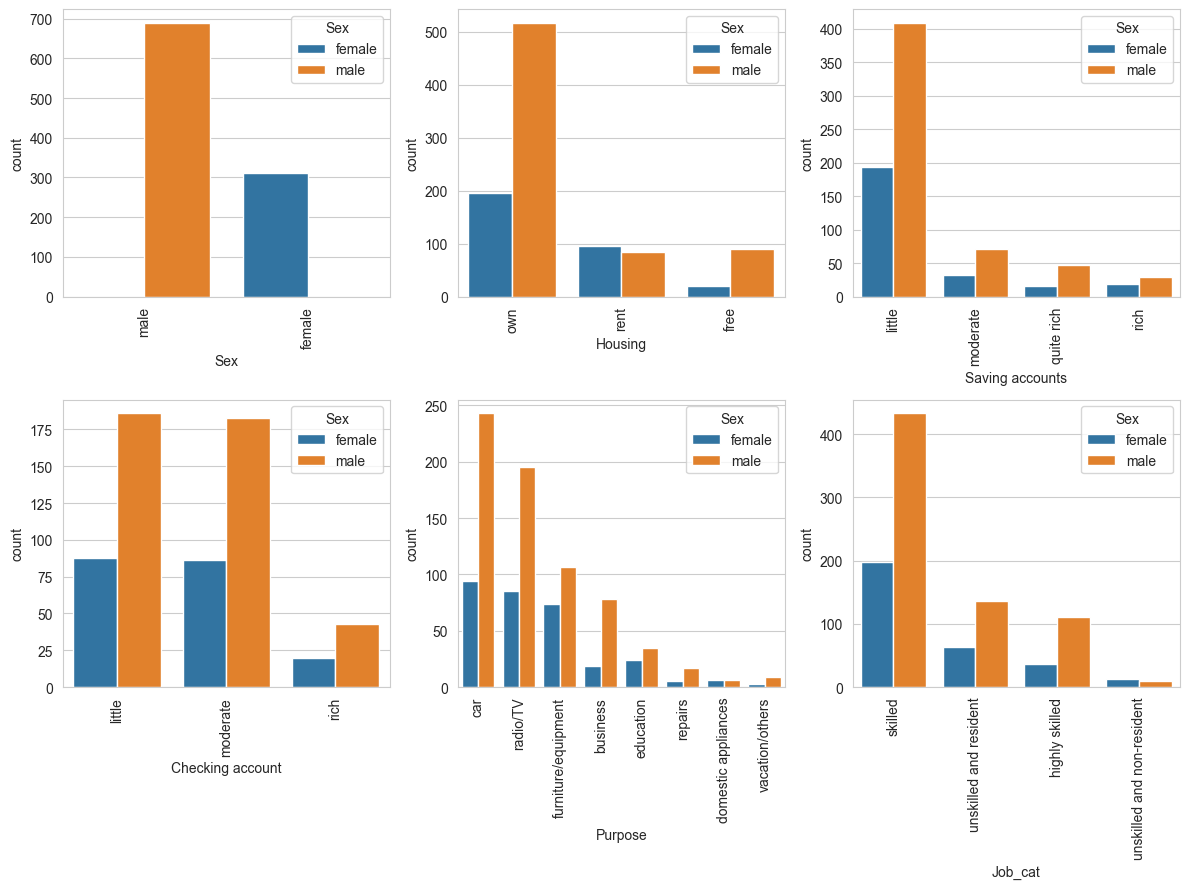

In [132]:
ncol = 3
nrow = ceil(len(cat_vars)/ncol)
fig, axes = plt.subplots(nrow, ncol)
fig.set_size_inches(ncol*4, nrow*4.5)
for ax, cat in zip(axes.flatten(), cat_vars):
    sns.countplot(data=df, x=cat, ax=ax, hue='Sex', order=df[cat].value_counts().index)
    ax.tick_params('x', labelrotation=90)
plt.tight_layout()
plt.show()

Стоит отметить, что датасет репрезентативен в разрезе пола, в каждой категории примерно такое же соотношение женщин и мужчин как во всем датасете.

## Numeric variables
Посмотрим на распределение числовых признаков

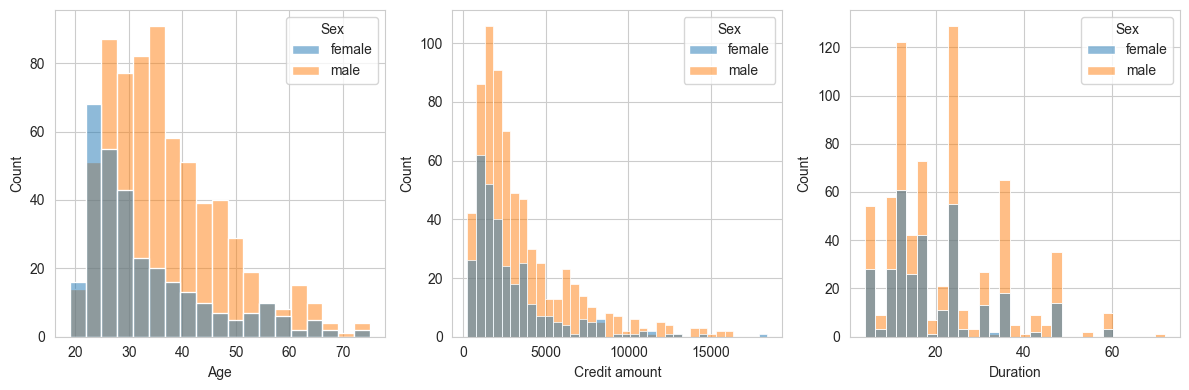

In [133]:
num_vars = df.select_dtypes(exclude='category').drop('Job', axis=1).columns
multiple_plots(df, num_vars, sns.histplot, hue='Sex')
plt.tight_layout()
plt.show()

Распределение возраста и суммы кредита приблизительно нормальные со скосом вправо, а срок кредита отдаленно напоминает его.

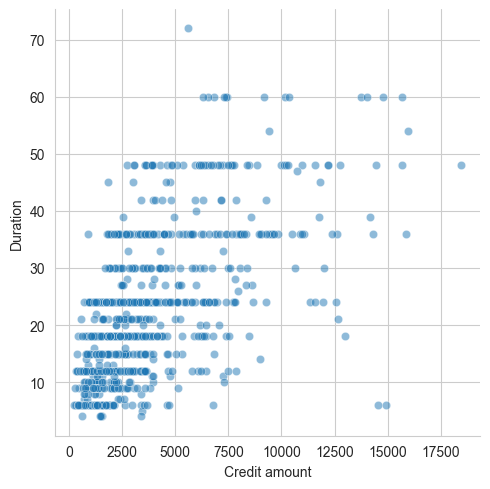

In [134]:
sns.relplot(data=df, x='Credit amount', y='Duration', alpha=0.5)
plt.show()

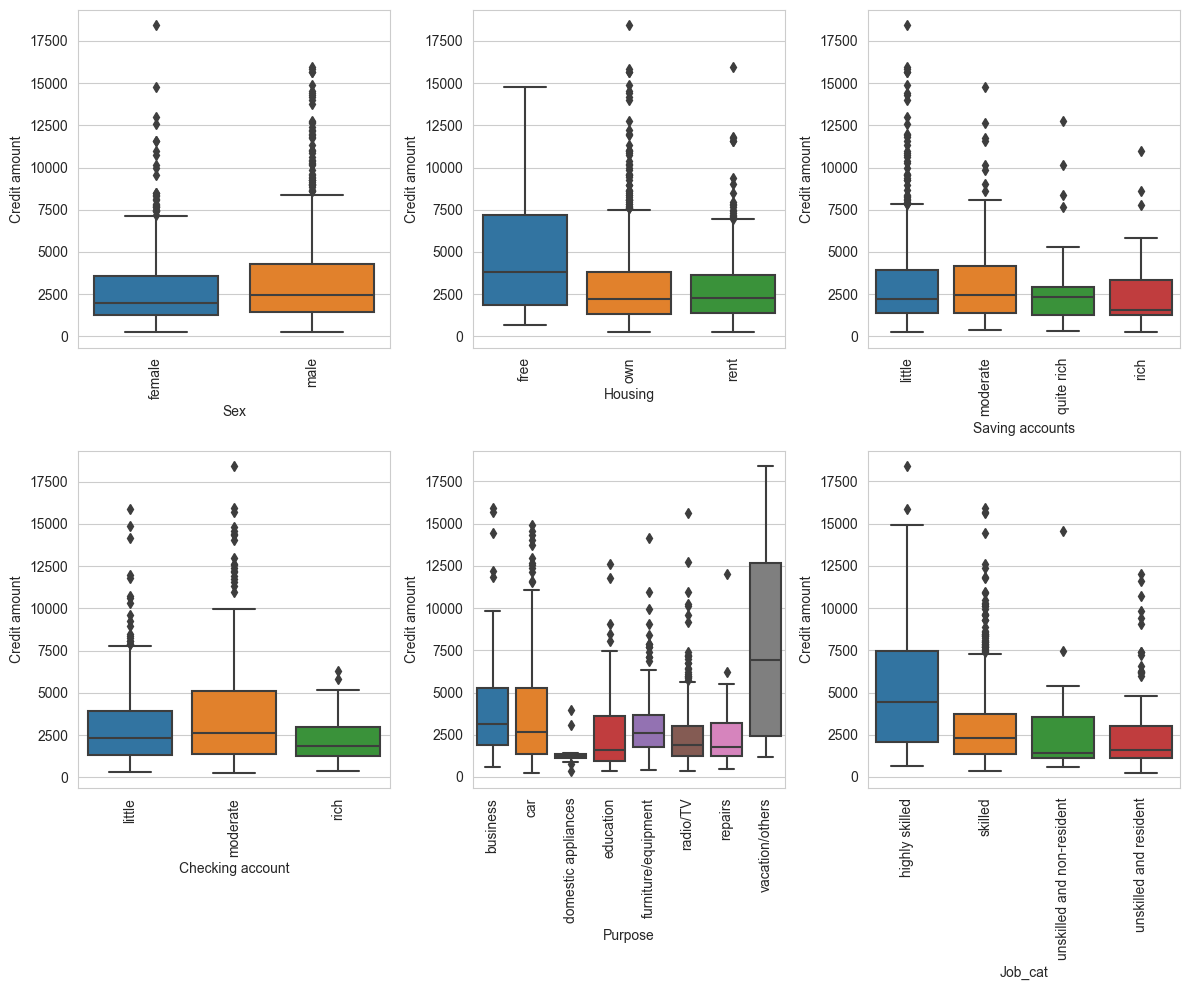

In [135]:
accounts = ['Saving accounts', 'Checking account', 'Job_cat']
multiple_plots(df, cat_vars, sns.boxplot, y='Credit amount', xyrot=(90,0), gheight=5)
plt.tight_layout()
plt.show()

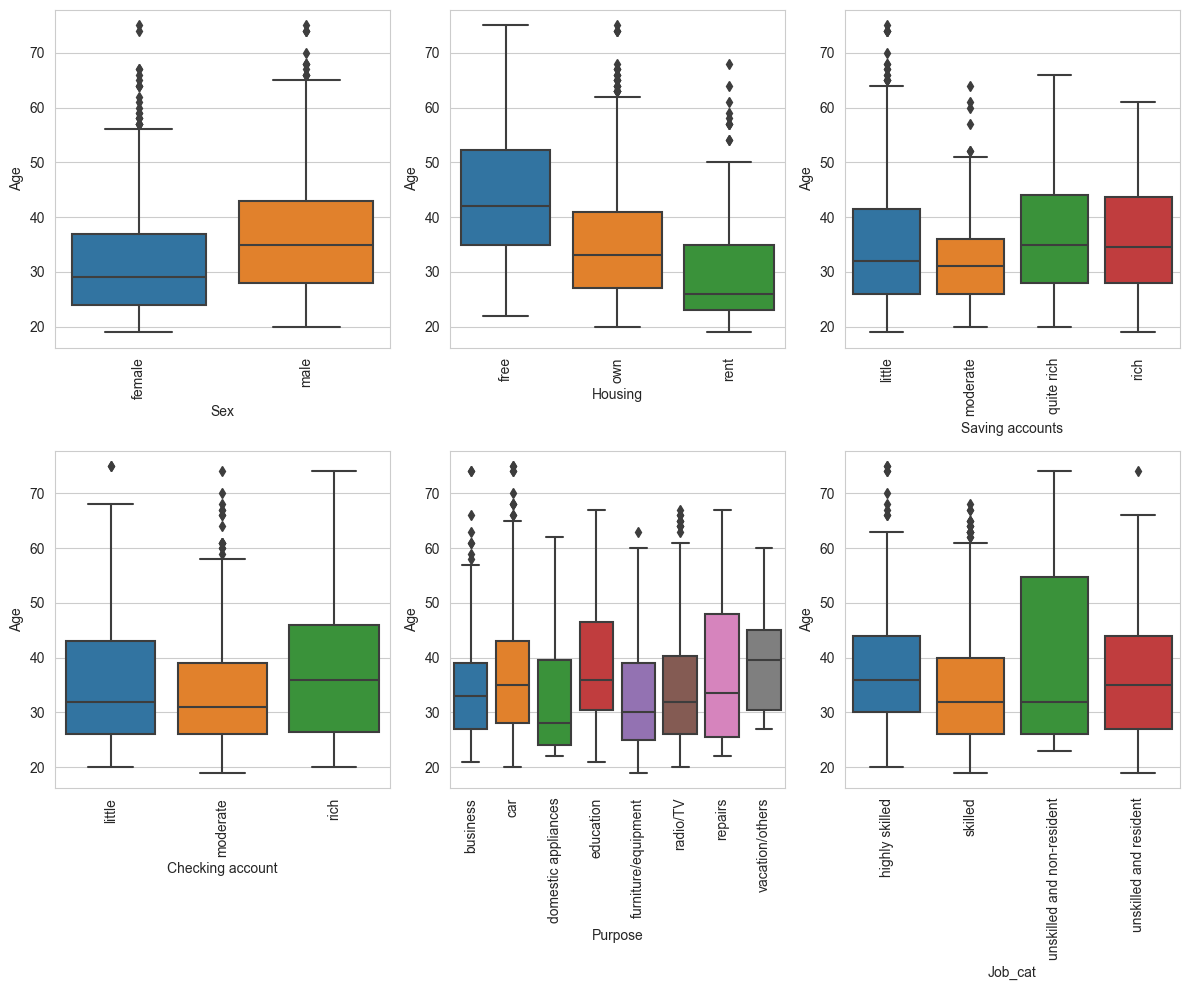

In [136]:
multiple_plots(df, cat_vars, sns.boxplot, y='Age', xyrot=(90,0), gheight=5)
plt.tight_layout()
plt.show()

In [137]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Job_cat
0,67,male,2,own,NaN,little,1169,6,radio/TV,skilled
1,22,female,2,own,little,moderate,5951,48,radio/TV,skilled
2,49,male,1,own,little,NaN,2096,12,education,unskilled and resident
3,45,male,2,free,little,little,7882,42,furniture/equipment,skilled
4,53,male,2,free,little,little,4870,24,car,skilled
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,unskilled and resident
996,40,male,3,own,little,little,3857,30,car,highly skilled
997,38,male,2,own,little,NaN,804,12,radio/TV,skilled
998,23,male,2,free,little,little,1845,45,radio/TV,skilled


## Data Pre-processing
Нужно закодировать категориальные данные:
- Sex
- Housing
- Saving accounts
- Checking account  
- Purpose

Все будем кодировать с помощью OrdinalEncoder, использование dummy variables излишне увеличит размерность простанства.

In [144]:
ordinal = ['Housing', 'Saving accounts', 'Checking account']
nominal = ['Sex', 'Purpose']
# ordinal categories order
housing_ord = ['free', 'rent', 'own']
savacc_ord = ['little', 'moderate', 'quite rich', 'rich', np.nan]
checkacc_ord = ['little', 'moderate', 'rich', np.nan]
enc_cat = [housing_cat, savacc_ord, checkacc_ord]
# encoder for ordinal
ordenc = OrdinalEncoder(categories=enc_cat).set_params(encoded_missing_value=-1)
# encoder for other categorical
enc = OrdinalEncoder()
# copy features
X = df.drop('Job_cat', axis=1).copy(deep=True)
# encode
X[ordinal] = ordenc.fit_transform(X[ordinal])
X[nominal] = enc.fit_transform(X[nominal])
X

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1.0,2,2.0,-1.0,0.0,1169,6,5.0
1,22,0.0,2,2.0,0.0,1.0,5951,48,5.0
2,49,1.0,1,2.0,0.0,-1.0,2096,12,3.0
3,45,1.0,2,0.0,0.0,0.0,7882,42,4.0
4,53,1.0,2,0.0,0.0,0.0,4870,24,1.0
...,...,...,...,...,...,...,...,...,...
995,31,0.0,1,2.0,0.0,-1.0,1736,12,4.0
996,40,1.0,3,2.0,0.0,0.0,3857,30,1.0
997,38,1.0,2,2.0,0.0,-1.0,804,12,5.0
998,23,1.0,2,0.0,0.0,0.0,1845,45,5.0


Последний шаг - приведение данных к одному масштабу, чтобы все признаки имели одинаковое влияние на кластеризацию.

In [145]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Dimension Reduction
Применим алгоритмы уменьшения размерности для визуализации данных на двумерной плоскости

In [148]:
def scatter_noticks (x, y, ax=None, labels=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.tick_params(labelbottom=False, labelleft=False)
    sns.set_style('white')
    sns.scatterplot(x=x, y=y, ax=ax, hue=labels)
    
def visualise_dimred(dimred, dimred_labs, data_labs=None, ncol=3):
    nplot = len(dimred)
    nrow = ceil(nplot/ncol)
    fig, axes = plt.subplots(1, ncol)
    fig.set_size_inches(5*ncol, 4)
    for i, dr in enumerate(dimred):
        scatter_noticks(dr[:,0], dr[:,1], axes[i], data_labs)
        axes[i].set_title(dimred_labs[i])
    return fig, axes

viz_dr = partial(visualise_dimred, 
                 dimred=[X_pca, X_tsne, X_umap], 
                 dimred_labs=['PCA', 't-SNE', 'UMAP'])

### PCA

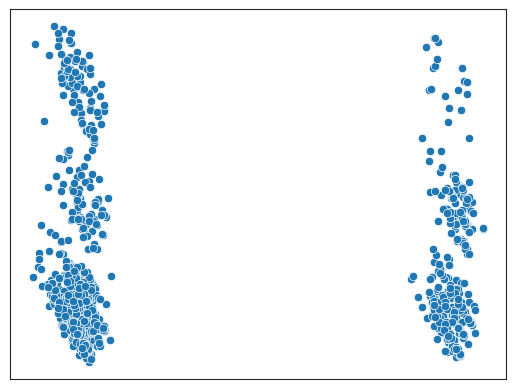

In [149]:
pca = PCA()
X_pca = pca.fit_transform(X)

scatter_noticks(X_pca[:,0], X_pca[:,1])
plt.show()

### t-SNE

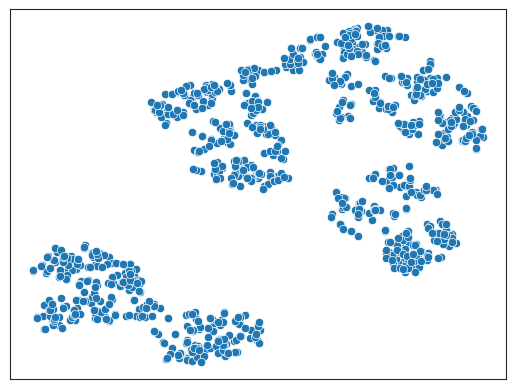

In [150]:
tsne = TSNE(n_components=2, random_state=77)
X_tsne = tsne.fit_transform(X)

scatter_noticks(x=X_tsne[:, 0], y=X_tsne[:, 1])
plt.show()

### UMAP

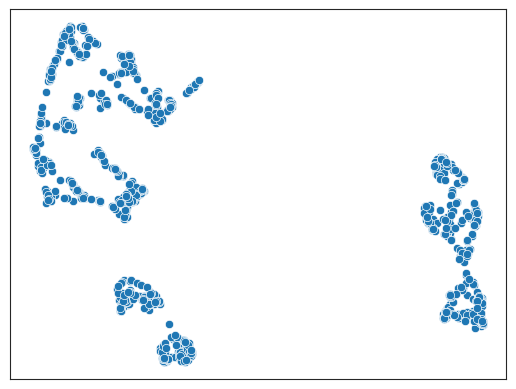

In [151]:
reducer = umap.UMAP(random_state=77)
X_umap = reducer.fit_transform(X)

scatter_noticks(x=X_umap[:, 0], y=X_umap[:, 1])
plt.show()

## Clusterisation

### K-Means
Сперва нужно выбрать количество кластеров. Для этого применим метод логтя и силуэтный коэффициент.

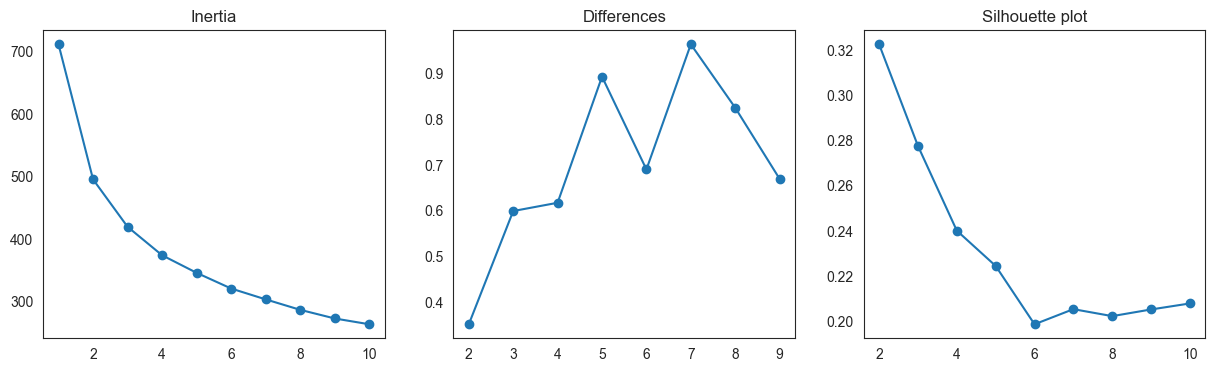

In [152]:
# calculate inertia and silhouette score
inertia = []
silhouette = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=77).fit(X)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)
    if i != 1:
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        silhouette.append(score)
# calculate differences
D = []
for i in range(1,9):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)
# Visualising
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 4)
# inertia plot
ax[0].set_title('Inertia')
ax[0].plot(range(1,11), inertia, marker='o')
# D
ax[1].set_title('Differences')
ax[1].plot(range(2,10), D, marker='o')
# silhouette score
ax[2].set_title('Silhouette plot')
ax[2].plot(range(2,11), silhouette, marker='o')
plt.show()

По обоим методам выходит, что лучшее количество кластеров - 2

Обучим модель и визуализируем результаты работы алгоритма:

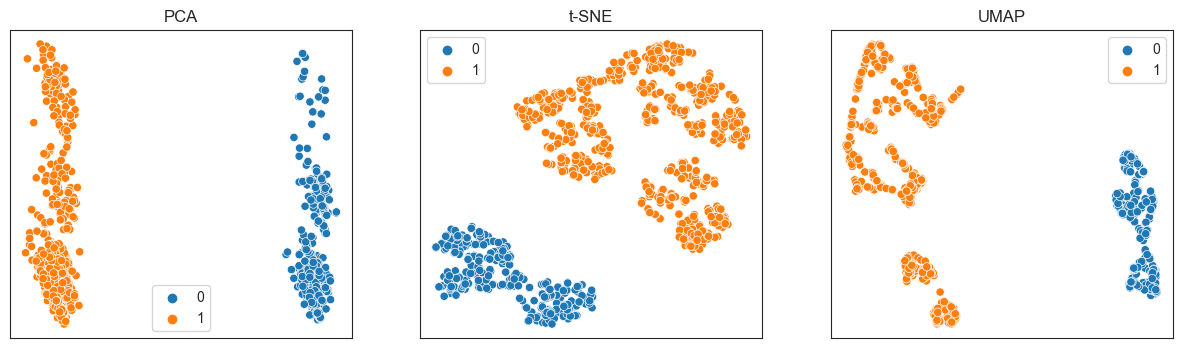

In [183]:
# Training model
kmeans = KMeans(n_clusters=2, random_state=77).fit(X)
# Getting results
labels = kmeans.labels_
# Visualising
fig, axes = viz_dr(dimred=[X_pca, X_tsne, X_umap], data_labs=labels)
plt.show()

### Hierarchical clustering (agglomerative)
Посмотрим на дендрограмму:

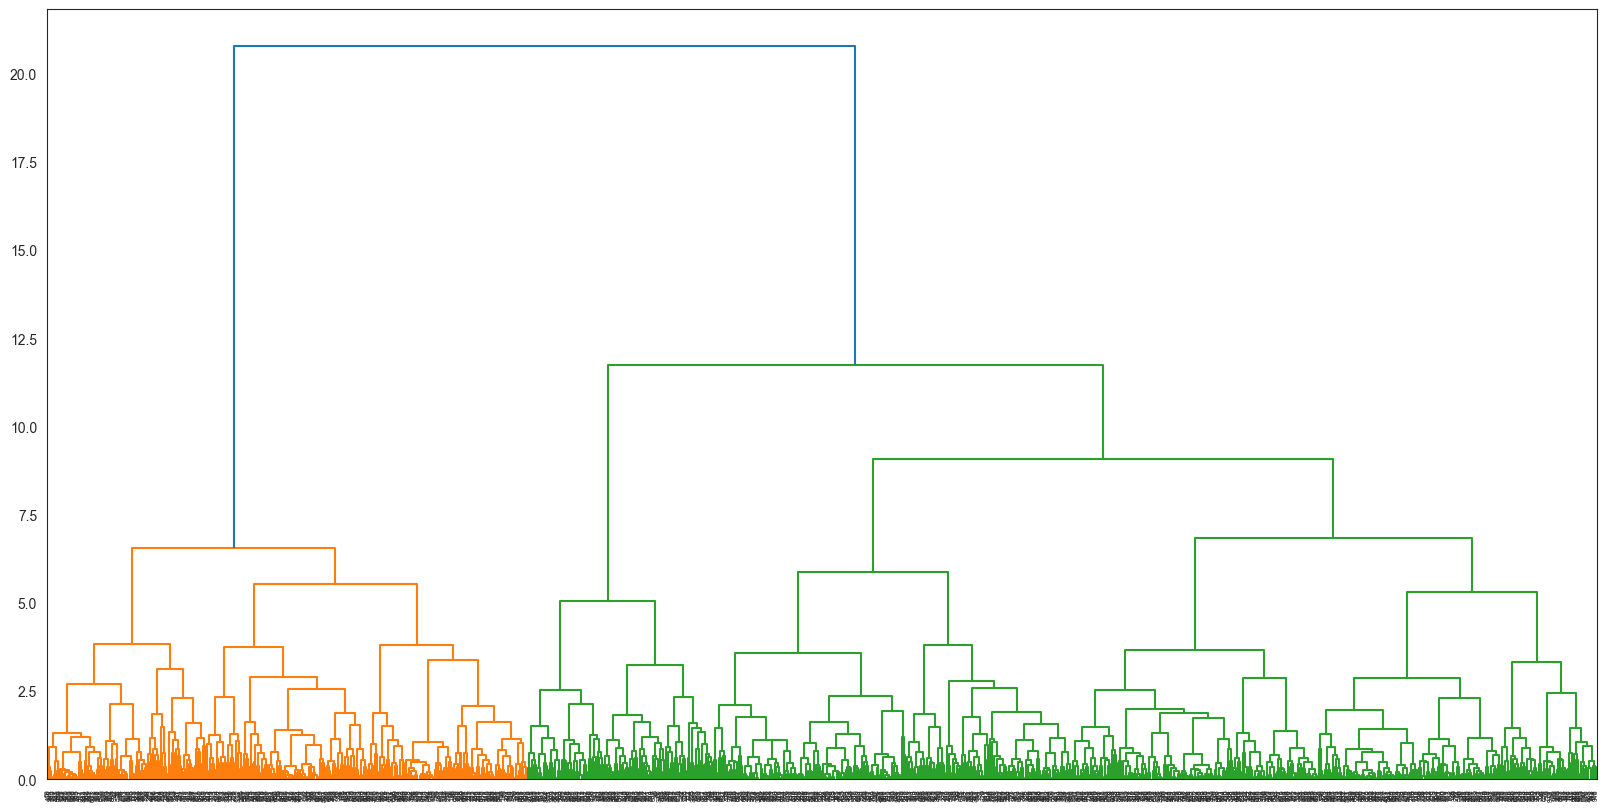

In [171]:
plt.figure(figsize=(20,10))
linkage_ = linkage(X, method='ward')
dendrogram_ = dendrogram(linkage_)

Визульно похоже, что выделяются два кластера. Проверим это с помощь силуэтного коэффициента:

In [177]:
# calculate silhouette score
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(X)
    labels = agg.labels_
    score = silhouette_score(X, labels)
    silhouette.append(score)

100%|██████████| 9/9 [00:01<00:00,  6.36it/s]


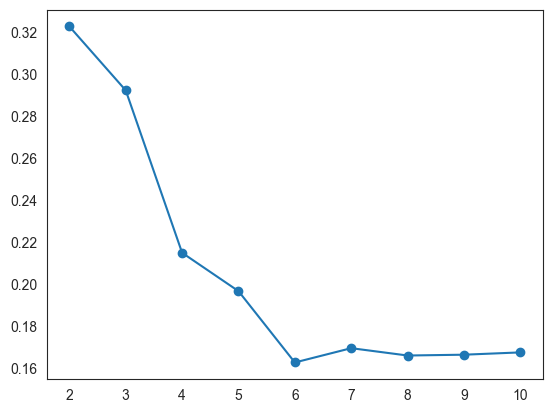

In [172]:
plt.plot(range(2,11), silhouette, marker='o')
plt.show()

Выделяем два кластера, обучаем модель и визуализируем результат работы:

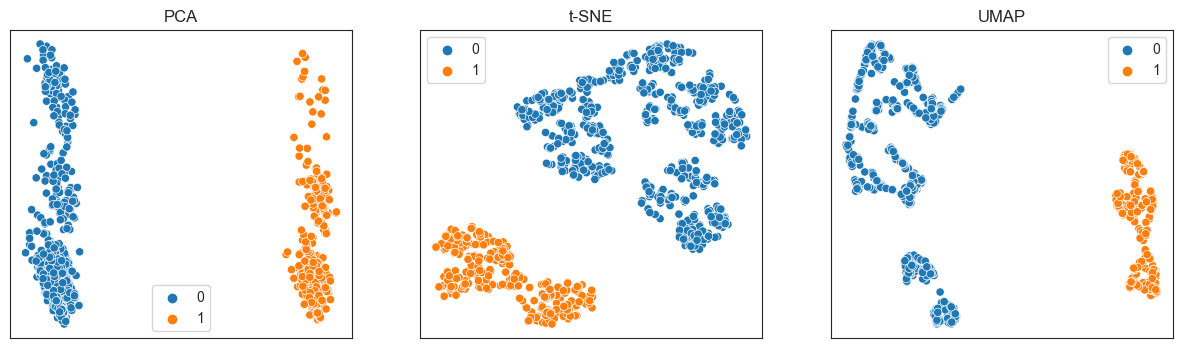

In [188]:
# Training model
agg = AgglomerativeClustering(n_clusters=2).fit(X)
# Getting results
labels = agg.labels_
# Visualising
fig, axes = viz_dr(dimred=[X_pca, X_tsne, X_umap], data_labs=labels)
plt.show()

### DBSCAN
Для работы алгоритма нам нужно подобрать значения гиперпараметров. Будем подбирать размер окружности $\epsilon$ с помощью силуэтного коэффициента и стабильности в количестве находимых кластеров.

In [179]:
def plot_sil_nclust (eps, sil, nclust):
    fig, ax = plt.subplots()
    color = 'tab:red'
    color = 'tab:red'
    ax.plot(eps, sil, marker='o', color=color)
    ax.set_xlabel('eps')
    ax.set_ylabel('silhouette', color=color)
    ax.tick_params(axis='y', labelcolor=color)

    ax_tw = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax_tw.plot(eps, nclust, marker='o', color=color)
    ax_tw.set_ylabel('n_clusters', color=color)  
    ax_tw.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    return fig

100%|██████████| 19/19 [00:02<00:00,  9.13it/s]


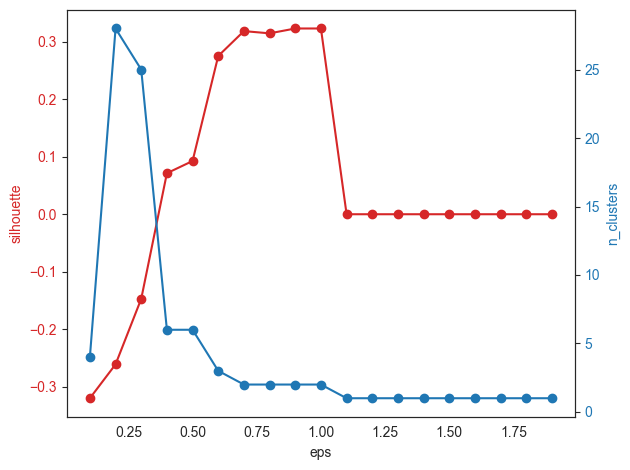

In [180]:
# calculate silhouette score and number of clusters
silhouette = []
clusters = []
eps_range = np.arange(0.1,2,0.1)
for i in tqdm(eps_range):
    dbscan = DBSCAN(eps=i).fit(X)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(X, labels)
    else:
        score = 0
    silhouette.append(score)
    clusters.append(n_clusters)
plot_sil_nclust(eps_range, silhouette, clusters)
plt.show()

Силуэтный коэффициент максимален для $\epsilon$ в промежутке между 0,75 и 1. Расмотрим этот диазон в деталях:

100%|██████████| 36/36 [00:05<00:00,  6.62it/s]


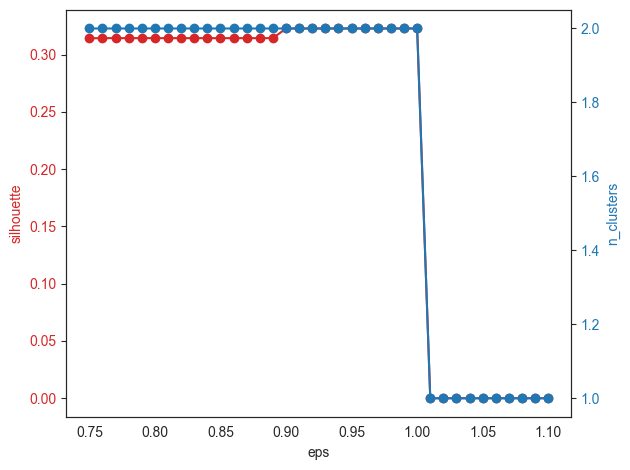

In [181]:
# calculate silhouette score and number of clusters
silhouette = []
clusters = []
eps_range = np.arange(0.75,1.1,0.01)
for i in tqdm(eps_range):
    dbscan = DBSCAN(eps=i).fit(X)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(X, labels)
    else:
        score = 0
    silhouette.append(score)
    clusters.append(n_clusters)
plot_sil_nclust(eps_range, silhouette, clusters)
plt.show()

В качестве $\epsilon$ возьмем 0,95, обучим модель и визуализируем данные:

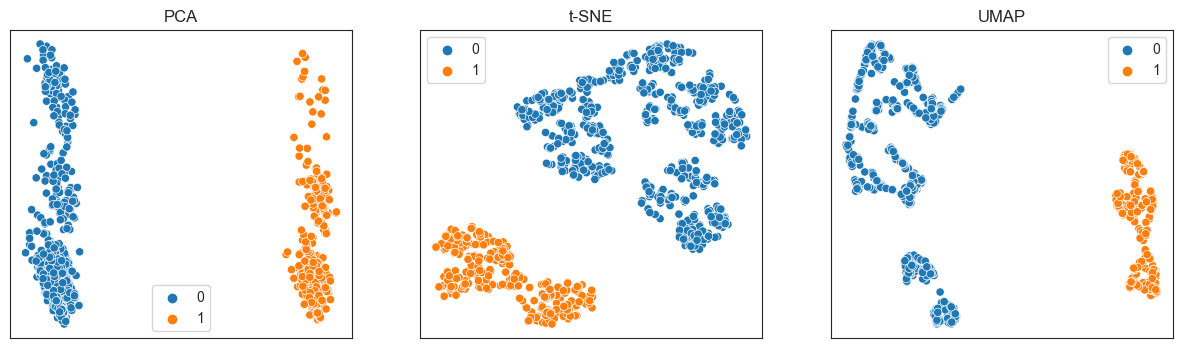

In [184]:
# Training model
dbscan = DBSCAN(eps=0.95).fit(X)
# Getting results
labels = dbscan.labels_
# Visualising
fig, axes = viz_dr(dimred=[X_pca, X_tsne, X_umap], data_labs=labels)
plt.show()

## Interpretation